### Mecab
* Text segmentation library to segment a sentence written in Korean or Japanese
* Often used to distinguish significant words from unnecessary words, such as a, the, and, etc,.

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, io, re, random
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
plt.style.use('seaborn-v0_8-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

### Issues with the review data
* 5 stars reviews with negative comments (Users believe companies often focus on feedbacks  with positive reviews)
* Prevent the modeling from having high accuracy --> eliminate half of the five-star ratings

In [ ]:
url = 'https://drive.google.com/file/d/1-0fKeA-i1QuN_mpLuCS0zU7NUP1DlsTi/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

df.sort_values('rating', ascending=False, inplace=True)
numFiveRating = len(df.loc[df['rating'] == 5])

### Data Cleansing
* Delete rows with null values
* Remove anything in sentences except Korean characters and blanks  

In [ ]:
print(df.isnull().sum())
df = df.dropna()
df = df.iloc[int(numFiveRating/2):, :]

labels = []
for i in range(0, len(df)):
  if df.iloc[i,3] > 3:
    labels.append(1)
  else:
    labels.append(0)

df['label'] = labels

Unnamed: 0     0
date           0
review        48
rating        20
isEdited       7
title         68
dtype: int64


In [ ]:
df['review'] = df['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex=True)

In [ ]:
df['review'].replace('', np.nan, inplace=True)
print(len(df))
print(df.isnull().sum())
df = df.dropna()
print(len(df))

74775
Unnamed: 0      0
date            0
review        238
rating          0
isEdited        0
title           0
label           0
dtype: int64
74537


# LSTM Network

### Tokenize and remove stopwords
* Split words and delete stop words
* Stopwords examples (Korean): '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다'

In [ ]:
# Oversampling
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
print(sorted(Counter(df_train['label']).items()))
from imblearn.over_sampling import RandomOverSampler, SMOTE
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(df_train['review'].values.reshape(-1 ,1), df_train['label'].values.reshape(-1, 1))
print(sorted(Counter(y_train_ros).items()))

[(0, 33955), (1, 25674)]
[(0, 33955), (1, 33955)]


In [ ]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [ ]:
mecab = Mecab()
X_train = []
for i in range(0,len(X_train_ros[:][:])):
  for sentence in X_train_ros[i][:]:
    X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

# for sentence in df_train['review']:
#     X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [ ]:
X_test = []
for sentence in df_test['review']:
  X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'하': 1, '고': 2, '을': 3, '있': 4, '안': 5, '는데': 6, '주': 7, '되': 8, '게': 9, '면': 10, '네요': 11, '해': 12, '세요': 13, '좋': 14, '어': 15, '지': 16, '보': 17, '만': 18, '다': 19, '없': 20, '거': 21, '로': 22, '습니다': 23, '수': 24, '겠': 25, '너무': 26, '어요': 27, '것': 28, '같': 29, '했': 30, '기': 31, '할': 32, '에서': 33, '앱': 34, '나': 35, '제': 36, '업데이트': 37, '영상': 38, '시': 39, '인': 40, '왜': 41, '않': 42, '었': 43, '다시': 44, '계정': 45, '사용': 46, '때': 47, '사람': 48, '뜨': 49, '불편': 50, '기능': 51, '쓰': 52, '아요': 53, '틱톡': 54, '진짜': 55, '요': 56, '으면': 57, '아니': 58, '제발': 59, '저': 60, '합니다': 61, '다른': 62, '해서': 63, '아': 64, '계속': 65, '삭제': 66, 'ㅠㅠ': 67, '싶': 68, '서': 69, '스타': 70, '어서': 71, '번': 72, '많': 73, '입니다': 74, '은데': 75, '사진': 76, '배달': 77, '플': 78, '그': 79, '못': 80, '다가': 81, '적': 82, '개': 83, '화면': 84, '전': 85, '더': 86, '데': 87, '정말': 88, '말': 89, '분': 90, '라고': 91, '오류': 92, '던': 93, '해요': 94, '나요': 95, '만들': 96, '받': 97, '았': 98, '죠': 99, '들어가': 100, '지만': 101, '부터': 102, '일': 103, '갑자기': 104, '시간': 105, '니':

### Eliminate words with low frequency
* Filter out words  with low frequency (they will not affect the result significantly)  
* Set threshold to be 3, removing words which frequencies are less than 3

In [ ]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print("Total Number of Words:", words_cnt)
print("Rare Words with Frequencies <= {} : {}".format(threshold-1, rare_cnt))
print("Percentage of Rare Words: {}".format((rare_cnt / words_cnt)*100))

Total Number of Words: 29950
Rare Words with Frequencies <= 2 : 16270
Percentage of Rare Words: 54.32387312186978


In [ ]:
vocab_size = words_cnt-rare_cnt+2
print(vocab_size)

13682


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# y_train = np.array(df_train['label'])
y_train = y_train_ros
y_test = np.array(df_test['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
print(len(X_train))
print(len(y_train))

67717
67717


### Padding
* Proceed padding to use the batch mode later
* Set the length to be 60 based on the distribution below

In [ ]:
  print('Max length of review:', max(len(l) for l in X_train))
  print('Avg. length of review:', sum(map(len, X_train))/len(X_train))

Max length of review: 741
Avg. length of review: 40.16060959581789


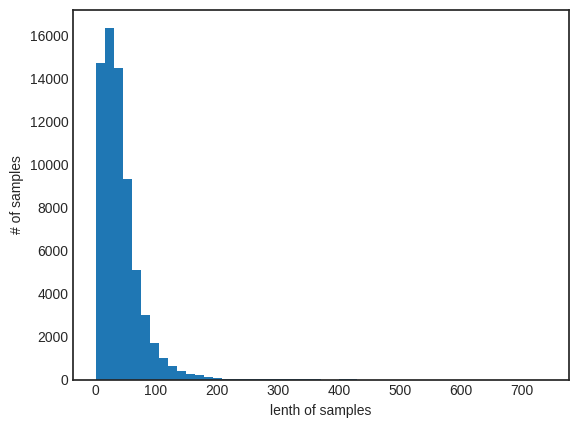

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('lenth of samples')
plt.ylabel('# of samples')
plt.show()

In [ ]:
max_len = 60
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### Model Building and Learning Process

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow

In [ ]:
model = Sequential(
    [
        Embedding(vocab_size, 100),
        LSTM(128),
        tensorflow.keras.layers.Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ]
)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1368200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1486089 (5.67 MB)
Trainable params: 1485833 (5.67 MB)
Non-trainable params: 256 (1.00 KB)
__________________

In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=60, validation_split=0.2)

Epoch 1/15
903/903 [==============================] - 39s 32ms/step - loss: 0.5352 - acc: 0.7373 - val_loss: 1.0233 - val_acc: 0.5114
Epoch 2/15
903/903 [==============================] - 11s 12ms/step - loss: 0.4816 - acc: 0.7779 - val_loss: 0.5377 - val_acc: 0.7301
Epoch 3/15
903/903 [==============================] - 9s 10ms/step - loss: 0.4570 - acc: 0.7939 - val_loss: 0.5337 - val_acc: 0.7415
Epoch 4/15
903/903 [==============================] - 9s 9ms/step - loss: 0.4373 - acc: 0.8042 - val_loss: 0.4793 - val_acc: 0.7756
Epoch 5/15
903/903 [==============================] - 8s 8ms/step - loss: 0.4172 - acc: 0.8150 - val_loss: 0.4739 - val_acc: 0.7820
Epoch 6/15
903/903 [==============================] - 8s 9ms/step - loss: 0.3992 - acc: 0.8256 - val_loss: 0.5167 - val_acc: 0.7662
Epoch 7/15
903/903 [==============================] - 9s 10ms/step - loss: 0.3787 - acc: 0.8370 - val_loss: 0.4353 - val_acc: 0.8146
Epoch 8/15
903/903 [==============================] - 8s 8ms/step - lo

In [ ]:
model.evaluate(X_test, y_test)

466/466 [==============================] - 2s 4ms/step - loss: 0.7559 - acc: 0.7322


[0.7558907270431519, 0.7322242856025696]

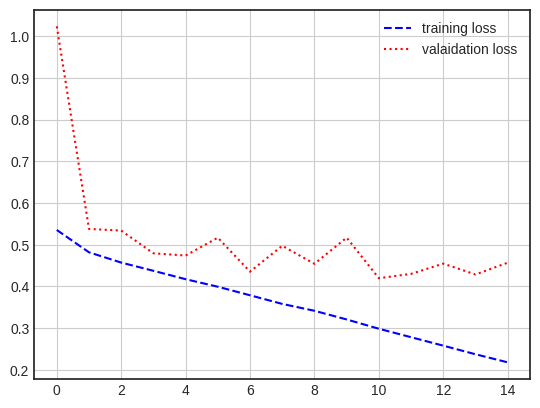

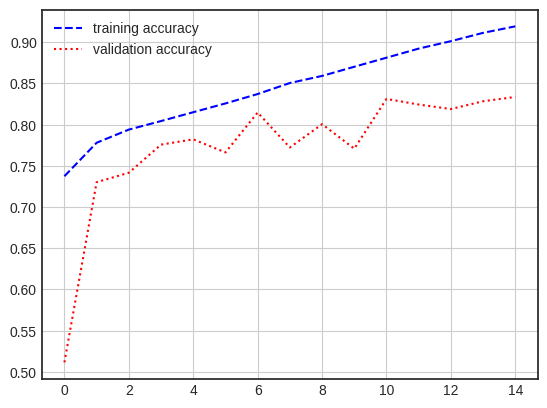

In [ ]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label='training loss')
plt.plot(val_loss, 'r:', label='valaidation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label='training accuracy')
plt.plot(val_acc, 'r:', label='validation accuracy')
plt.legend()
plt.grid()

In [ ]:
predict_y = model.predict(X_test)
for i in range(0,len(predict_y)):
  predict_y[i][0] = round(predict_y[i][0],0)
classes_y = np.argmax(predict_y, axis=1)

466/466 [==============================] - 2s 3ms/step


In [ ]:
print(classes_y.unique())

AttributeError: ignored

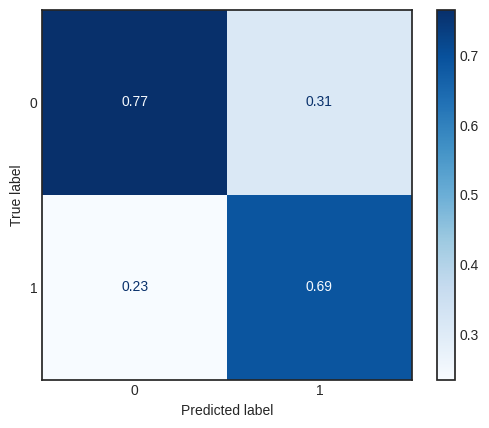

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, predict_y , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = [0,1])
disp.plot(cmap="Blues")
plt.show()

# SVM

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from nltk.tokenize import TweetTokenizer

DF = df
count = 0
random_index = []
while count < int(len(DF)/5):
  random_index.append(random.randint(0, int(len(DF)/5) - 1))
  count += 1

new_Xtrain_ros = [X_train_ros[i] for i in random_index]
new_ytrain_ros = [y_train_ros[i] for i in random_index]
#new_Xtrain_ros = [list(element) for element in new_Xtrain_ros]
#new_ytrain_ros = [list(element) for element in new_Xtrain_ros]

def tokenize(text):
  mecab = Mecab()
  return mecab.morphs(text)

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = stopwords)

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

np.random.seed(1)
pipeline_svm = make_pipeline(vectorizer,
                            SVC(probability=True, kernel="linear"))
grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]},
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1)

#X_train_ros_ = np.array(new_ytrain_ros, dtype=object)
#y_train_ros_ = np.array(new_ytrain_ros, dtype=object)
X_train_ros_ = pd.DataFrame(new_Xtrain_ros)
X_train_ros_ = X_train_ros_.squeeze()
y_train_ros_ = pd.DataFrame(new_ytrain_ros)
y_train_ros_ = y_train_ros_.squeeze()

grid_svm.fit(X_train_ros_, y_train_ros_)
grid_svm.score(df_test['review'], df_test['label'])

print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 1}
0.8761232469559899


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [ ]:
report_results(grid_svm.best_estimator_, x_ts, y_ts)

{'auc': 0.8970588235294118,
 'f1': 0.8749999999999999,
 'acc': 0.8620689655172413,
 'precision': 0.9333333333333333,
 'recall': 0.8235294117647058}

In [ ]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

roc_svm = get_roc_curve(grid_svm.best_estimator_, x_ts, y_ts)

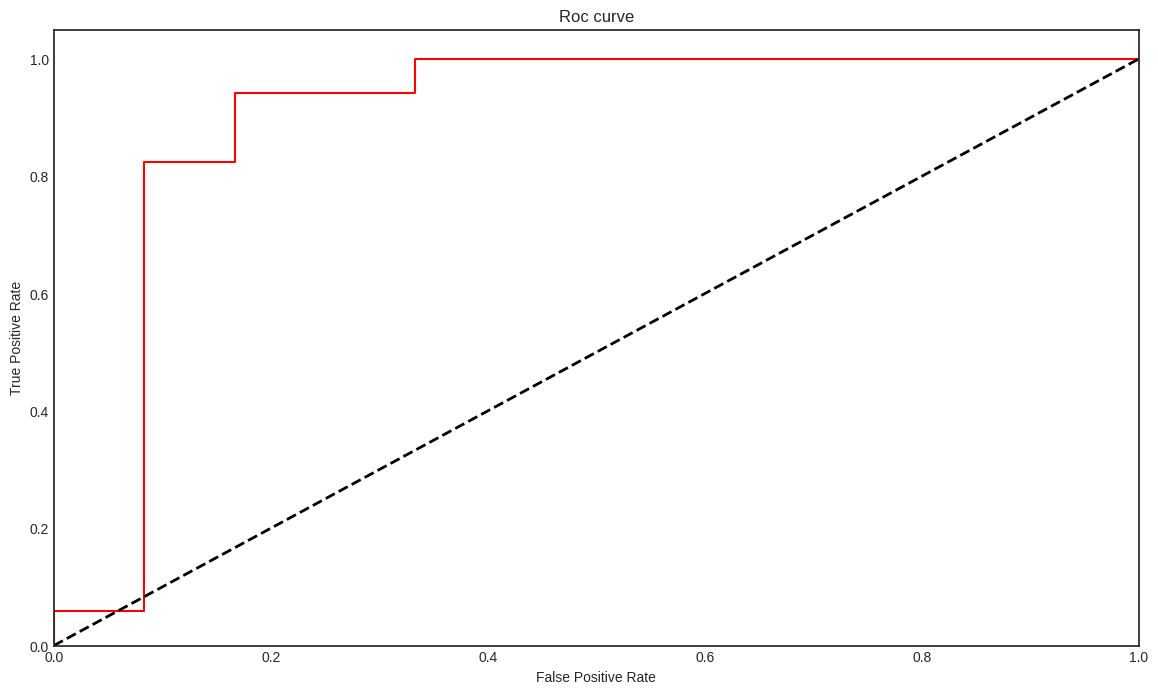

In [ ]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

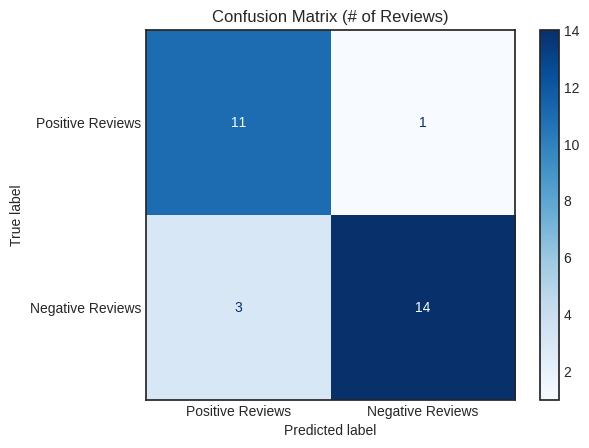

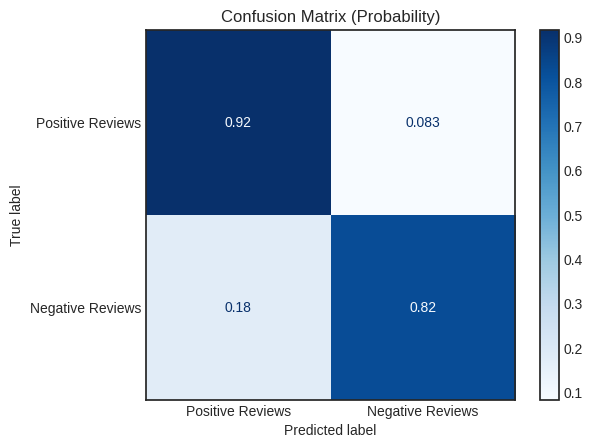

In [ ]:
titles_options = [
    ("Confusion Matrix (# of Reviews)", None),
    ("Confusion Matrix (Probability)", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        grid_svm,
        x_ts,
        y_ts,
        display_labels= ["Positive Reviews", "Negative Reviews"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()